In [85]:
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from IS18 import vistools
from IS18 import utils
from IS18 import triangulation

from bundle_adjust import ba_utils

import warnings
warnings.filterwarnings('ignore')

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set input directory and load AOI coordinates

In [86]:
site = 'IARPA'
method = 'ncc_alignment' # ba_offsets, ba_rotations, ncc_alignment
order = 'heuristic'

exp_name = '{}_{}_{}'.format(site, method, order)
input_dir = os.path.join('exp/',exp_name)


# load aoi

if site == 'IARPA':
    aoi = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                            [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field
else:
    mygts = utils.listFD('http://138.231.80.166:2332/grss-2019/track_3/Track3-Truth-geolocated/', '_DSM.tif')
    mygt_fn = [i for i in mygts if site in i]
    aoi = utils.get_image_longlat_polygon(mygt_fn[0])
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field
    
if os.path.isdir(input_dir):
    print('Experiment name is valid, AOI successfully loaded')
else:
    print('Experiment not found')

Experiment name is valid, AOI successfully loaded


### Create DSMs

In [87]:
os.makedirs(input_dir+'/dsm', exist_ok=True)

# use the aoi to set the limits of the grid where the point clouds will be projected to DSMs
emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi)
px_size = 0.300000011920929 # to set the DSMs resolution

# project all point colouds to DSMs
print('Creating DSMs...')
ply_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/clouds')][0]
for iter_cont, filename in enumerate(ply_files):
    xyz = ba_utils.read_point_cloud_ply(input_dir+'/clouds/'+filename)
    dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=px_size)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/dsm/dsm_{}.tif'.format(os.path.splitext(filename[12:])[0]))
    print('\r{} / {} done'.format(iter_cont+1, len(ply_files)), end = '\r')
print('\nDone!\n')

Creating DSMs...
50 / 50 done
Done!



### Post-process DSMs

In [88]:
os.makedirs(input_dir+'/cdsm', exist_ok=True)
if method == 'ncc_alignment':
    os.makedirs(input_dir+'/mcdsm', exist_ok=True)
    os.makedirs(input_dir+'/rcdsm', exist_ok=True)
    os.makedirs(input_dir+'/ncc_transform', exist_ok=True)

print('Post-processing DSMs...')
dsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/dsm')][0]
  
for iter_cont, filename in enumerate(dsm_files):
    dsm = input_dir+'/dsm/'+filename # original dsm

    # small hole interpolation by closing
    cdsm = input_dir+'/cdsm/c'+filename  # dsm after closing
    os.system('bin/morsi square closing {0} | bin/plambda {0} - "x isfinite x y isfinite y nan if if" -o {1}'.format(dsm, cdsm))
    
    if method == 'ncc_alignment':
        # larger holes with min interpolation
        mcdsm = input_dir+'/mcdsm/mc'+filename  # dsm after closing and min interpolation
        os.system('bin/bdint5pc -a min {} {}'.format(cdsm, mcdsm))
    
    print('\r{} / {} done'.format(iter_cont+1, len(dsm_files)), end = '\r')
print('\nDone!\n')

if method == 'ncc_alignment':

    if site in ['JAX_113', 'JAX_161', 'JAX_251']:
        reference_pair = (17,18) # first pair from 'list_of_pairs'
    if site == 'IARPA':
        reference_pair = (38,39)
    
    a, b = reference_pair[0], reference_pair[1]
    ref_dsm = input_dir+'/dsm/dsm_{:02}_{:02}.tif'.format(a,b)
    ref_cdsm = input_dir+'/cdsm/cdsm_{:02}_{:02}.tif'.format(a,b)
    ref_mcdsm = input_dir+'/mcdsm/mcdsm_{:02}_{:02}.tif'.format(a,b)
    print('Selected pair {:02}_{:02} as the reference one'.format(a,b))

    # align DSMs using 3D translations maximizing the NCC of their geometry
    print('Aligning DSMs...')
    for iter_cont, filename in enumerate(dsm_files):
        cdsm = input_dir+'/cdsm/c'+filename
        mcdsm = input_dir+'/mcdsm/mc'+filename
        rcdsm = input_dir+'/rcdsm/rc'+filename
        trans = input_dir+'/ncc_transform/t_'+os.path.splitext(filename)[0]+'.txt'  

        # compute horizontal registration on the interpolated DSMs
        os.system('bin/ncc_compute_shift {} {} 5 > {}'.format(ref_mcdsm, mcdsm, trans))
        dx, dy = np.loadtxt(trans)[:2]

        # compute vertical registration on the original DSMs
        os.system('bin/ncc_compute_shift {} {} 5 {} {} > {}'.format(ref_cdsm, cdsm, dx, dy, trans))

        # apply the registration
        os.system('bin/ncc_apply_shift {} `cat {}` {}'.format(cdsm, trans, rcdsm))
        print('\r{} / {} done'.format(iter_cont+1, len(dsm_files)), end = '\r')
    print('\nDone!\n')

Post-processing DSMs...
50 / 50 done
Done!

Selected pair 38_39 as the reference one
Aligning DSMs...
50 / 50 done
Done!



### Fuse aligned DSMs

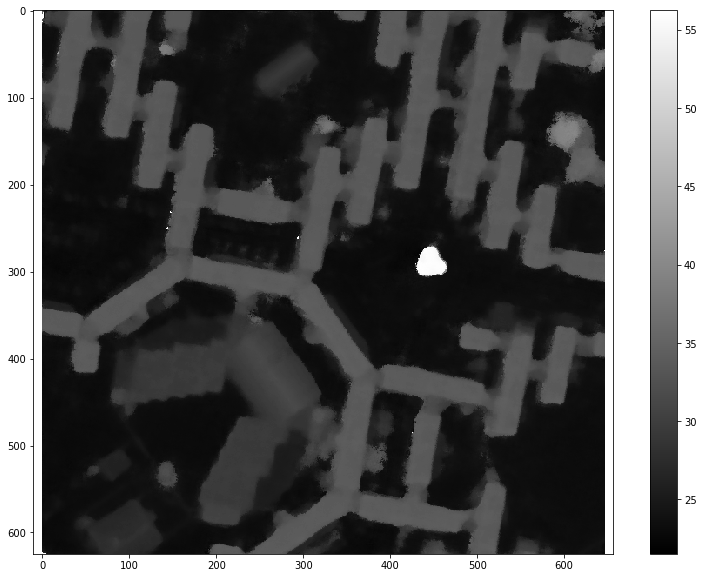

In [89]:
os.makedirs(input_dir+'/output', exist_ok=True)

src_dir = input_dir+'/rcdsm' if method == 'ncc_alignment' else input_dir+'/cdsm'

# stack the N output DSMs in a WxHxN grid
rcdsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(src_dir)][0]
olist = [os.path.join(src_dir, filename) for filename in rcdsm_files]
u=[]
for ofile in olist:
    u.append(np.array(Image.open(ofile)))
stacked_rcdsm = np.dstack(u)

# pointwise median to fuse all DSMs
fusion_result = np.nanmedian(stacked_rcdsm, axis=2)

# visualize the number of samples per pixel
nan_idx = np.isnan(stacked_rcdsm)
obs_per_px = np.sum((~nan_idx).astype(int), axis=2).astype(float)

#vistools.display_imshow(obs_per_px)
vistools.display_imshow(fusion_result)
im = Image.fromarray(fusion_result)
im.save(input_dir+'/output/fused_dsm.tif')

### Prepare GT DSM

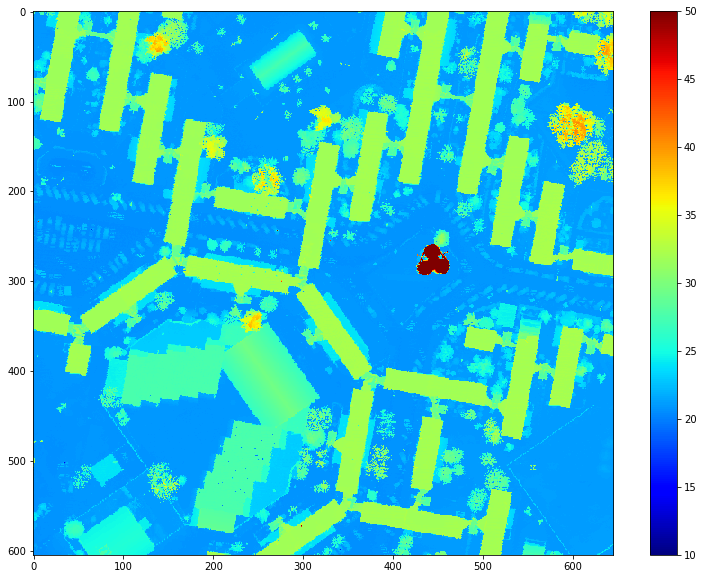

In [91]:
# prepare GT dem to obtain performance score

emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi)
px_size = 0.300000011920929

# read the ground truth geotiff 
gt_dsm = np.array(Image.open('gt/'+site+'_gt.tif'))

if site == 'IARPA':
    # write the necessary data from gdalinfo (northing (y) needs to be expressed in negative coordinates)
    epsg, x, y, px_size = 32721, 354449.320, 6182457.920 - 10000000, 0.300000011920929
    # attention: the top-left corner from the gt tiff and the one from the aoi are not exactly coincident
    # save the gt geotiff but this time with northing in negative coordinates
    ba_utils.save_geotiff(input_dir+'/gt_dsm2.tif', gt_dsm.astype(np.float64), epsg, x, y, r=px_size)
else:
    os.system('cp gt/'+site+'_gt.tif '+input_dir+'/gt_dsm2.tif')

# elevate the geotiff we just wrote and write the point cloud in a ply file
os.system('bin/elevate '+input_dir+'/gt_dsm2.tif > '+input_dir+'/gt_cloud.txt')
os.remove(input_dir+'/gt_dsm2.tif')
xyz = ba_utils.read_point_cloud_txt(input_dir+'/gt_cloud.txt')
os.remove(input_dir+'/gt_cloud.txt')
ba_utils.write_point_cloud_ply(input_dir+'/gt_cloud.ply', xyz)

# project the recently created point cloud into the aoi and create a dem
xyz = ba_utils.read_point_cloud_ply(input_dir+'/gt_cloud.ply')
dem_3,dem_nan,dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=px_size)

# save the dem as the new ready-to-be-used gt
im = Image.fromarray(dem_nan)
im.save(input_dir+'/gt_dsm_nan.tif')

# filter those values where we do not have gt available
rows_with_gt = ~np.all(np.isnan(dem_nan), axis=1)
cols_with_gt = ~np.all(np.isnan(dem_nan), axis=0)
dem_3 = dem_3[rows_with_gt, :]
dem_3 = dem_3[:, cols_with_gt]
im = Image.fromarray(dem_3)
im.save(input_dir+'/gt_dsm_registered.tif')

if site == 'IARPA':
    vistools.display_imshow(dem_3, cmap='jet', range=(10,50))
else:
    vistools.display_imshow(dem_3, cmap='jet', range=(5,-25))

### Register solution and ground-truth DSMs

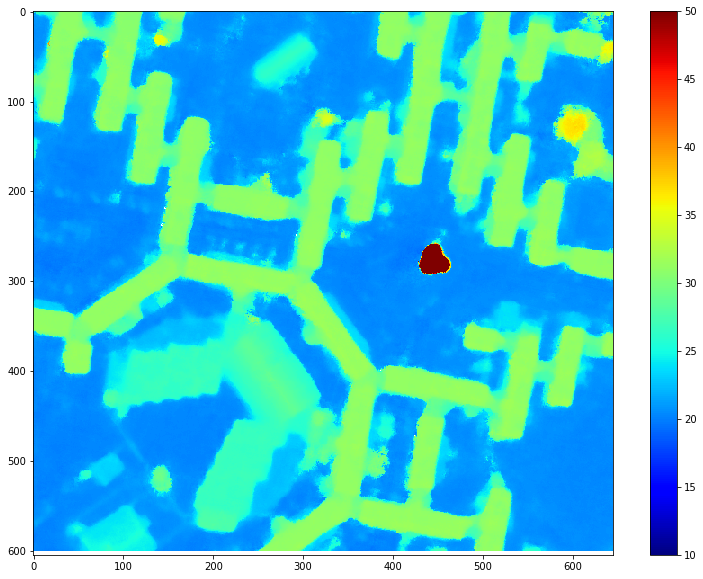

In [92]:
# prepare SOL dem to obtain performance score

# read fused and gt dem
out_dsm = np.array(Image.open(input_dir+'/output/fused_dsm.tif'))
gt_dsm  = np.array(Image.open(input_dir+'/gt_dsm_nan.tif'))

# filter those values where we do not have gt available
rows_with_gt = ~np.all(np.isnan(gt_dsm), axis=1)
cols_with_gt = ~np.all(np.isnan(gt_dsm), axis=0)
out_dsm2 = out_dsm[rows_with_gt, :]
out_dsm2 = out_dsm2[:, cols_with_gt]
im = Image.fromarray(out_dsm2)
im.save(input_dir+'/output/fused_dsm2.tif')

out_dsm = input_dir+'/output/fused_dsm2.tif'
gt_dsm  = input_dir+'/gt_dsm_registered.tif'

# compute horizontal registration on the interpolated DSMs
trans = input_dir+'/output/t_sol.txt'
os.system('bin/ncc_compute_shift {} {} 5 > {}'.format(gt_dsm, out_dsm, trans))
dx, dy = np.loadtxt(trans)[:2]

# compute vertical registration on the original DSMs
os.system('bin/ncc_compute_shift {} {} 5 {} {} > {}'.format(gt_dsm, out_dsm, dx, dy, trans))

# apply the registration
os.system('bin/ncc_apply_shift {} `cat {}` {}'.format(out_dsm, trans, input_dir+'/output/sol_dsm_registered.tif'))

# copy geotiff properties from the gt dsm to the sol dsm
#os.system('python gdalcopyproj.py {} {}'.format(gt_dsm, input_dir+'/sol_dsm.tif'))

os.remove(input_dir+'/output/fused_dsm2.tif')
sol_dsm = np.array(Image.open(input_dir+'/output/sol_dsm_registered.tif'))

if site == 'IARPA':
    vistools.display_imshow(sol_dsm, cmap='jet', range=(10,50))
else:
    vistools.display_imshow(sol_dsm, cmap='jet', range=(5,-25))

### Evaluation

score: 67.54621665164797
nan: 0.004096010485781676
mean_e: 1.4815643
median_e: 0.6831455
std_e: 2.232725


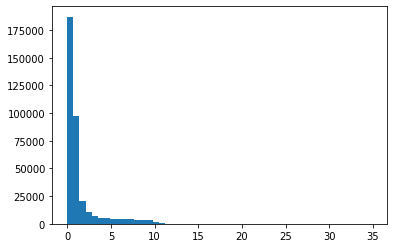

In [93]:
#input_dir = 'exp/JAX_161_ba_rotations_heuristic'

dem_gt = np.array(Image.open(input_dir+'/gt_dsm_registered.tif'))[10:-10,10:-10]
dem_sol = np.array(Image.open(input_dir+'/output/sol_dsm_registered.tif'))[10:-10,10:-10]

# compute mse and completness (i.e. % of px with error lower than 1 m)
# first remove possible nans from the solution
idx = ~np.isnan(dem_sol)
dem_gt2, dem_sol2 = dem_gt[idx], dem_sol[idx]
#total_px = dem_gt2.shape[0]
nan_values = 100 - ((dem_gt2.shape[0]/ (dem_gt.shape[0] * dem_gt.shape[1]) ) * 100)
mean_e = np.mean((abs(dem_gt2 - dem_sol2)))
median_e = np.median(abs(dem_gt2 - dem_sol2))
std_e = np.std(abs(dem_gt2 - dem_sol2))
total_px = dem_gt.shape[0] * dem_gt.shape[1]
completness = sum( (abs(dem_gt2 - dem_sol2) < 1.0).astype(int) ) / total_px * 100

plt.hist(abs(dem_gt2 - dem_sol2), bins=50) 

print('score:', completness)
print('nan:', nan_values)
print('mean_e:', mean_e)
print('median_e:', median_e)
print('std_e:', std_e)